In [1]:
!pip install -q rasterstats
!pip install -q odc-stac -U

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterstats
import rioxarray as rxr
import rasterio
import adlfs
import contextily as ctx
from tqdm import tqdm
from pathlib import Path

In [3]:
#from dask.distributed import Client, LocalCluster
#cluster = LocalCluster(processes=False, n_workers=4, local_directory='/tmp')
#client = Client(cluster)
#client

In [4]:
import dask_gateway
cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.adapt(minimum=10, maximum=100)
print(client.dashboard_link)

https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.599a05fa58e74b0b949b9326ad9ec45a/status


In [5]:
gf = gpd.read_file('https://raw.githubusercontent.com/scottyhq/snotel/967b0071f3716118bfcae866c740cffb51fbb5f5/snotel-sites.geojson')

In [6]:
gf

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,mgrs,timeseries,geometry
0,301_CA_SNTL,Adin Mtn,1886.712036,41.235828,-120.791924,Modoc,California,1983-10-01 00:00:00,2100-01-01,True,10TFL,True,POINT (-120.79192 41.23583)
1,907_UT_SNTL,Agua Canyon,2712.719971,37.522171,-112.271179,Kane,Utah,1994-10-01 00:00:00,2100-01-01,True,12SUG,True,POINT (-112.27118 37.52217)
2,916_MT_SNTL,Albro Lake,2529.840088,45.597229,-111.959023,Madison,Montana,1996-09-01 00:00:00,2100-01-01,True,12TVR,True,POINT (-111.95902 45.59723)
3,1267_AK_SNTL,Alexander Lake,48.768002,61.749668,-150.889664,Matanuska-Susitna,Alaska,2014-08-28 00:00:00,2100-01-01,True,05VPJ,True,POINT (-150.88966 61.74967)
4,908_WA_SNTL,Alpine Meadows,1066.800049,47.779572,-121.698471,King,Washington,1994-09-01 00:00:00,2100-01-01,True,10TET,True,POINT (-121.69847 47.77957)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,877_AZ_SNTL,Workman Creek,2103.120117,33.812420,-110.917732,Gila,Arizona,1938-12-01 00:00:00,2100-01-01,True,12SWC,True,POINT (-110.91773 33.81242)
926,1228_UT_SNTL,Wrigley Creek,2842.869629,39.132332,-111.356850,Sanpete,Utah,2012-10-01 00:00:00,2100-01-01,True,12SVJ,True,POINT (-111.35685 39.13233)
927,1197_UT_SNTL,Yankee Reservoir,2649.321533,37.747971,-112.774948,Iron,Utah,2012-10-01 00:00:00,2100-01-01,True,12SUG,True,POINT (-112.77495 37.74797)
928,878_WY_SNTL,Younts Peak,2545.080078,43.932251,-109.817749,Park,Wyoming,1979-10-01 00:00:00,2100-01-01,True,12TWP,True,POINT (-109.81775 43.93225)


In [7]:
snotel_gf = gf[gf.isActive==True]
snotel_gf = snotel_gf[(snotel_gf.beginDate<'2015-01-01') & (snotel_gf.endDate>'2022-01-01')]
snotel_gf = snotel_gf[snotel_gf.state!='Alaska']

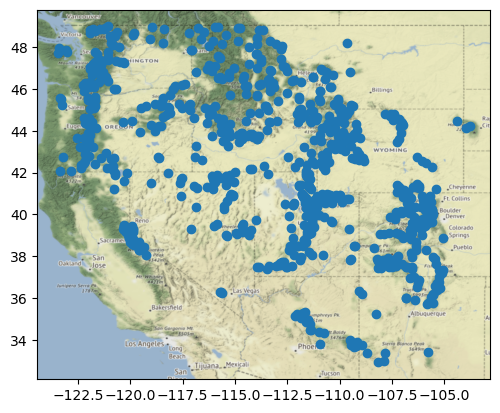

In [8]:
f,ax=plt.subplots()
snotel_gf.plot(ax=ax)
ctx.add_basemap(ax=ax, crs=snotel_gf.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

In [9]:
years = [2015,2016,2017,2018,2019,2020,2021,2022]
#years = [2016,2017,2018,2019,2020,2021,2022]
#years = [2017,2018,2019,2020,2021,2022]
max_swe_years = [f'max_swe_{year}' for year in years]

In [10]:
#for i,row in tqdm(snotel_gf.iterrows()):
#    try:
#        snotel_data = pd.read_parquet(f'https://github.com/scottyhq/snotel/raw/main/parquet/{row.code}.parquet').loc[slice(f'{years[0]}-01-01',f'{years[-1]}-12-31')]
#        snotel_data = snotel_data[(snotel_data.index.month>1)&(snotel_data.index.month<10)]
#        dates = snotel_data.groupby(snotel_data.index.year).idxmax()['WTEQ']
    #print(dates)
#        if len(dates)==len(years):
#            snotel_gf.loc[i,max_swe_years] = dates.values
#    except:
#        pass
    #date_index = []
    #for date in dates.index.values:
    #    date_index.append(f'max_swe_{date}')
    #snotel_gf = snotel_gf.loc[i,iter(date_index)] = dates.loc[2015:2022]

In [11]:
%%time
my_file = Path("snotel_gf_comparison.geojson")
if my_file.is_file():
    snotel_gf = gpd.read_file('snotel_gf_comparison.geojson')
else:
    for i,row in tqdm(snotel_gf.iterrows()):
        try:
            snotel_data = pd.read_parquet(f'https://github.com/scottyhq/snotel/raw/main/parquet/{row.code}.parquet').loc[slice(f'{years[0]}-01-01',f'{years[-1]}-12-31')]
            snotel_data = snotel_data[(snotel_data.index.month>1)&(snotel_data.index.month<8)]

            dates = snotel_data.groupby(snotel_data.index.year).idxmax()['WTEQ']
            dates = dates[dates.notna()]
        #print(dates)
            #if len(dates)==len(years):
            #    snotel_gf.loc[i,max_swe_years] = dates.values
            for year in [date for date in dates.index]:
                snotel_gf.loc[i,f'max_swe_{year}'] = int(dates.dt.dayofyear[year])
        except:
            pass
        
        #for year in years:
        #    snotel_gf[f'max_swe_{year}'] = pd.to_datetime(snotel_gf[f'max_swe_{year}']).dt.dayofyear
            
    snotel_gf.to_file("snotel_gf_comparison.geojson", driver='GeoJSON')

CPU times: user 104 ms, sys: 14.3 ms, total: 119 ms
Wall time: 111 ms


In [12]:
snotel_gf

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,...,timeseries,max_swe_2015,max_swe_2016,max_swe_2017,max_swe_2018,max_swe_2019,max_swe_2020,max_swe_2021,max_swe_2022,geometry
0,301_CA_SNTL,Adin Mtn,1886.712036,41.235828,-120.791924,Modoc,California,1983-10-01 00:00:00,2100-01-01,True,...,True,32.0,51.0,68.0,86.0,75.0,32.0,74.0,76.0,POINT (-120.79192 41.23583)
1,907_UT_SNTL,Agua Canyon,2712.719971,37.522171,-112.271179,Kane,Utah,1994-10-01 00:00:00,2100-01-01,True,...,True,64.0,33.0,65.0,78.0,81.0,88.0,76.0,71.0,POINT (-112.27118 37.52217)
2,916_MT_SNTL,Albro Lake,2529.840088,45.597229,-111.959023,Madison,Montana,1996-09-01 00:00:00,2100-01-01,True,...,True,107.0,97.0,122.0,107.0,121.0,114.0,117.0,154.0,POINT (-111.95902 45.59723)
3,908_WA_SNTL,Alpine Meadows,1066.800049,47.779572,-121.698471,King,Washington,1994-09-01 00:00:00,2100-01-01,True,...,True,105.0,96.0,109.0,108.0,83.0,102.0,107.0,116.0,POINT (-121.69847 47.77957)
4,302_OR_SNTL,Aneroid Lake #2,2255.520020,45.213280,-117.192581,Wallowa,Oregon,1980-10-01 00:00:00,2100-01-01,True,...,True,99.0,122.0,123.0,112.0,112.0,117.0,106.0,135.0,POINT (-117.19258 45.21328)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,877_AZ_SNTL,Workman Creek,2103.120117,33.812420,-110.917732,Gila,Arizona,1938-12-01 00:00:00,2100-01-01,True,...,True,32.0,40.0,32.0,51.0,54.0,80.0,32.0,55.0,POINT (-110.91773 33.81242)
792,1228_UT_SNTL,Wrigley Creek,2842.869629,39.132332,-111.356850,Sanpete,Utah,2012-10-01 00:00:00,2100-01-01,True,...,True,63.0,89.0,66.0,82.0,89.0,90.0,83.0,76.0,POINT (-111.35685 39.13233)
793,1197_UT_SNTL,Yankee Reservoir,2649.321533,37.747971,-112.774948,Iron,Utah,2012-10-01 00:00:00,2100-01-01,True,...,True,63.0,91.0,94.0,64.0,81.0,88.0,86.0,80.0,POINT (-112.77495 37.74797)
794,878_WY_SNTL,Younts Peak,2545.080078,43.932251,-109.817749,Park,Wyoming,1979-10-01 00:00:00,2100-01-01,True,...,True,NaN,89.0,76.0,105.0,106.0,108.0,92.0,119.0,POINT (-109.81775 43.93225)


In [13]:
snotel_gf = snotel_gf.to_crs('EPSG:32611')

In [14]:
buffer = 500 # at 1000m with 2015 excluded, medians of medians at 38 days, with 500m 34 days, with 200m 36.25 days, with 2000m 37 days
# 27 days new method 500m method, 22.0 with 1000m new new method, 23.5 with 500m new new method, 22.0 with 2000m
snotel_gf_buff = gpd.GeoDataFrame(snotel_gf.copy(),geometry=snotel_gf.buffer(buffer))

In [15]:
snotel_gf

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,...,timeseries,max_swe_2015,max_swe_2016,max_swe_2017,max_swe_2018,max_swe_2019,max_swe_2020,max_swe_2021,max_swe_2022,geometry
0,301_CA_SNTL,Adin Mtn,1886.712036,41.235828,-120.791924,Modoc,California,1983-10-01 00:00:00,2100-01-01,True,...,True,32.0,51.0,68.0,86.0,75.0,32.0,74.0,76.0,POINT (182202.056 4571874.067)
1,907_UT_SNTL,Agua Canyon,2712.719971,37.522171,-112.271179,Kane,Utah,1994-10-01 00:00:00,2100-01-01,True,...,True,64.0,33.0,65.0,78.0,81.0,88.0,76.0,71.0,POINT (917980.554 4163320.291)
2,916_MT_SNTL,Albro Lake,2529.840088,45.597229,-111.959023,Madison,Montana,1996-09-01 00:00:00,2100-01-01,True,...,True,107.0,97.0,122.0,107.0,121.0,114.0,117.0,154.0,POINT (893146.663 5061670.452)
3,908_WA_SNTL,Alpine Meadows,1066.800049,47.779572,-121.698471,King,Washington,1994-09-01 00:00:00,2100-01-01,True,...,True,105.0,96.0,109.0,108.0,83.0,102.0,107.0,116.0,POINT (148062.869 5302498.875)
4,302_OR_SNTL,Aneroid Lake #2,2255.520020,45.213280,-117.192581,Wallowa,Oregon,1980-10-01 00:00:00,2100-01-01,True,...,True,99.0,122.0,123.0,112.0,112.0,117.0,106.0,135.0,POINT (484878.074 5006661.556)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
791,877_AZ_SNTL,Workman Creek,2103.120117,33.812420,-110.917732,Gila,Arizona,1938-12-01 00:00:00,2100-01-01,True,...,True,32.0,40.0,32.0,51.0,54.0,80.0,32.0,55.0,POINT (1063320.876 3758033.963)
792,1228_UT_SNTL,Wrigley Creek,2842.869629,39.132332,-111.356850,Sanpete,Utah,2012-10-01 00:00:00,2100-01-01,True,...,True,63.0,89.0,66.0,82.0,89.0,90.0,83.0,76.0,POINT (987900.153 4346652.811)
793,1197_UT_SNTL,Yankee Reservoir,2649.321533,37.747971,-112.774948,Iron,Utah,2012-10-01 00:00:00,2100-01-01,True,...,True,63.0,91.0,94.0,64.0,81.0,88.0,86.0,80.0,POINT (872299.352 4186264.528)
794,878_WY_SNTL,Younts Peak,2545.080078,43.932251,-109.817749,Park,Wyoming,1979-10-01 00:00:00,2100-01-01,True,...,True,NaN,89.0,76.0,105.0,106.0,108.0,92.0,119.0,POINT (1076540.895 4889486.939)


In [16]:
sas_token = 'se=2023-03-13T02%3A45Z&sp=racwdl&sv=2018-11-09&sr=c&skoid=b4d39ccb-ca9c-4e9d-a183-5e0f3ba3e609&sktid=f6b6dd5b-f02f-441a-99a0-162ac5060bd2&skt=2023-03-06T20%3A38%3A54Z&ske=2023-03-13T02%3A45%3A00Z&sks=b&skv=2018-11-09&sig=Nl9p59uFIaJRJgtbHhnVBgYgwh1MnZ/fcJrttie9gAM%3D'
tile_names = [tile[-5:] for tile in adlfs.AzureBlobFileSystem(account_name="snowmelt", credential=sas_token, anon=False).ls('snowmelt/eric/MGRS/')]

In [17]:
stats=['count', 'min', 'max', 'mean', 'median', 'std']

In [18]:
resolution = 80

In [19]:
#raster = rasterio.open(f"https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/{'13UDP'}/runoff_onset_{'13UDP'}_{2016}_median_{resolution}m.tif")
#raster.read(1)

In [20]:
for i,row in tqdm(snotel_gf.iterrows()):
    if row.mgrs in tile_names:
        #print(f'{row.code} in MGRS square {row.mgrs}')
        for year in years:
            try:
                raster = rasterio.open(f"https://snowmelt.blob.core.windows.net/snowmelt/eric/MGRS/{row.mgrs}/runoff_onset_{row.mgrs}_{year}_median_{resolution}m.tif")
                snotel_row_proj = snotel_gf_buff[snotel_gf_buff.index==i].to_crs(raster.crs)
                statistics = rasterstats.zonal_stats(snotel_row_proj, raster.read(1), affine=raster.transform, stats=stats, nodata=-32768)
                snotel_gf.loc[i,f'sar_runoff_{year}'] = statistics[0]['median']
                snotel_gf.loc[i,f'sar_runoff_{year}_std'] = statistics[0]['std']
                if year == 2022:
                    snotel_gf.loc[i,f'sar_runoff_pixel_count'] = statistics[0]['count']
            except:
                #print(f'Error with tile {row.mgrs} for year {year}')
                pass


796it [07:22,  1.80it/s]


In [21]:
for year in years:
        snotel_gf[f'offset_{year}'] = snotel_gf[f'max_swe_{year}'] - snotel_gf[f'sar_runoff_{year}']

In [22]:
snotel_gf['median_offset'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('offset')]].abs().median(axis=1)
snotel_gf['mean_offset'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.startswith('offset')]].abs().mean(axis=1)
snotel_gf['mean_std'] = snotel_gf[snotel_gf.columns[pd.Series(snotel_gf.columns).str.endswith('std')]].mean(axis=1)

In [23]:
snotel_gf.sort_values('mean_std').dropna()

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,...,offset_2016,offset_2017,offset_2018,offset_2019,offset_2020,offset_2021,offset_2022,median_offset,mean_offset,mean_std
503,669_CO_SNTL,North Lost Trail,2804.159912,39.078129,-107.143890,Gunnison,Colorado,1984-10-01,2100-01-01,True,...,-47.0,-45.0,-49.0,-1.0,10.0,3.0,-58.0,46.00,35.0000,0.000000
497,663_CO_SNTL,Niwot,3020.568115,40.035229,-105.544258,Boulder,Colorado,1979-10-01,2100-01-01,True,...,12.0,27.0,24.0,51.0,20.0,62.0,29.0,28.00,41.3750,0.000000
494,660_OR_SNTL,New Crescent Lake,1496.567993,43.511848,-121.979820,Klamath,Oregon,1979-10-01,2100-01-01,True,...,-101.0,2.0,-62.0,-101.0,12.0,-39.0,-47.0,54.50,54.8750,0.000000
489,657_MT_SNTL,N Fk Elk Creek,1905.000000,46.871601,-113.277252,Powell,Montana,1967-10-01,2100-01-01,True,...,4.0,-7.0,-5.0,-7.0,-14.0,-13.0,-16.0,10.00,11.2500,0.000000
469,643_UT_SNTL,Mosby Mtn.,2911.754395,40.607979,-109.888100,Uintah,Utah,1978-10-01,2100-01-01,True,...,-4.0,-9.0,20.0,38.0,43.0,4.0,-16.0,15.50,18.6250,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,939_CO_SNTL,Rough And Tumble,3157.728027,39.033329,-106.083328,Park,Colorado,1998-08-10,2100-01-01,True,...,-36.0,-33.0,-19.0,-36.0,-40.0,47.0,9.0,36.00,38.8750,37.844197
388,583_UT_SNTL,Little Grassy,1848.612061,37.486309,-113.845818,Washington,Utah,1985-10-01,2100-01-01,True,...,-77.0,-86.5,-53.0,-116.0,-42.0,-71.5,-103.0,74.25,76.4375,38.267822
575,721_OR_SNTL,Rock Springs,1612.391968,44.008831,-118.838417,Grant,Oregon,1979-10-01,2100-01-01,True,...,-129.5,-58.0,-109.0,-63.0,-81.0,-73.0,-44.5,77.00,80.1250,39.183044
563,715_NM_SNTL,Red River Pass #2,3002.280029,36.699249,-105.341248,Colfax,New Mexico,1978-10-01,2100-01-01,True,...,-88.0,-39.0,-62.0,-79.0,-60.0,-32.0,-37.0,61.00,57.7500,39.529558


In [24]:
snotel_gf = snotel_gf[(snotel_gf['mean_std']>0) & (snotel_gf['mean_std']<25)]

In [25]:
#snotel_gf.sort_values('mean_offset').dropna().tail(50)
snotel_gf.sort_values('mean_offset').head(20)

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,...,offset_2016,offset_2017,offset_2018,offset_2019,offset_2020,offset_2021,offset_2022,median_offset,mean_offset,mean_std
702,1013_UT_SNTL,Temple Fork,2257.348877,41.792999,-111.546051,Cache,Utah,2001-11-05,2100-01-01,True,...,5.0,-3.0,-3.0,-3.0,5.0,1.0,5.0,4.0,4.250000,17.699795
713,820_UT_SNTL,Timpanogos Divide,2481.072021,40.428169,-111.616333,Utah,Utah,1978-10-01,2100-01-01,True,...,-3.0,6.0,-9.0,0.0,2.0,2.0,-19.0,4.5,6.375000,16.461482
231,472_WY_SNTL,Evening Star,2804.159912,44.652580,-109.784218,Park,Wyoming,1979-10-01,2100-01-01,True,...,6.0,5.0,0.0,3.0,-15.0,-2.0,-1.0,4.0,7.000000,21.139618
15,311_MT_SNTL,Banfield Mountain,1706.880005,48.571201,-115.445732,Lincoln,Montana,1968-10-01,2100-01-01,True,...,-8.5,0.5,-5.5,17.0,-10.5,-7.5,NaN,7.5,7.357143,5.500000
738,837_WY_SNTL,Two Ocean Plateau,2816.352051,44.151779,-110.221222,Teton,Wyoming,1979-10-01,2100-01-01,True,...,-11.0,-2.0,-14.5,7.0,-13.5,-5.0,-6.0,6.5,7.437500,17.214417
687,803_ID_SNTL,Sunset,1688.592041,47.555450,-115.824219,Shoshone,Idaho,1978-10-01,2100-01-01,True,...,-12.5,6.0,-4.0,0.0,-14.0,-15.5,NaN,6.0,7.571429,9.068729
591,731_WY_SNTL,Sand Lake,3063.239990,41.462570,-106.281067,Carbon,Wyoming,1979-10-01,2100-01-01,True,...,4.5,-3.5,-5.5,13.0,-2.0,0.5,-13.0,5.0,7.625000,19.742299
428,615_NV_SNTL,Marlette Lake,2403.043213,39.163952,-119.896721,Carson City,Nevada,1978-10-01,2100-01-01,True,...,-2.0,9.0,0.0,-16.0,-9.0,-16.0,-1.0,9.0,7.937500,11.649378
523,971_UT_SNTL,Parrish Creek,2359.152100,40.934170,-111.813721,Davis,Utah,1999-10-01,2100-01-01,True,...,7.0,-21.0,2.0,-2.0,-13.5,-4.0,-7.0,7.0,7.937500,13.116319
19,314_WY_SNTL,Base Camp,2151.887939,43.940189,-110.445442,Teton,Wyoming,1979-10-01,2100-01-01,True,...,2.0,-24.0,-5.0,1.0,-7.0,-8.0,14.0,6.0,8.125000,12.423713


In [26]:
snotel_gf.sort_values('sar_runoff_pixel_count').dropna().tail(20)

,code,name,elevation_m,latitude,longitude,county,state,beginDate,endDate,isActive,...,offset_2016,offset_2017,offset_2018,offset_2019,offset_2020,offset_2021,offset_2022,median_offset,mean_offset,mean_std
717,1136_NV_SNTL,Toe Jam,2346.959961,41.318699,-116.340797,Elko,Nevada,2009-10-01,2100-01-01,True,...,9.0,8.0,-9.0,1.0,-7.0,-17.0,10.0,9.00,11.5000,21.517644
286,507_WA_SNTL,Grouse Camp,1642.871948,47.281071,-120.487709,Kittitas,Washington,1979-10-01,2100-01-01,True,...,-10.0,-22.0,-24.0,-30.0,-16.0,-18.0,12.5,20.00,24.0625,20.784861
285,506_WY_SNTL,Gros Ventre Summit,2667.000000,43.389389,-110.129433,Teton,Wyoming,1976-04-01,2100-01-01,True,...,7.0,7.0,-16.0,-23.0,-2.0,-10.0,57.0,13.00,17.8750,21.075701
237,477_OR_SNTL,Fish Creek,2334.768066,42.709919,-118.632103,Harney,Oregon,1978-10-01,2100-01-01,True,...,-21.0,12.0,6.0,-4.0,-7.0,-28.0,-1.0,9.50,16.2500,9.010957
274,1082_WY_SNTL,Grand Targhee,2822.447998,43.779331,-110.927834,Teton,Wyoming,2006-08-21,2100-01-01,True,...,14.0,-5.0,55.0,-16.0,-19.0,-20.0,-12.0,17.50,20.8750,12.251806
200,450_ID_SNTL,Dollarhide Summit,2566.416016,43.602501,-114.674171,Blaine,Idaho,1979-10-01,2100-01-01,True,...,-24.0,4.0,-3.0,3.0,-11.0,-9.0,31.0,10.00,15.0000,20.455971
680,800_OR_SNTL,Summer Rim,2157.983887,42.695702,-120.801582,Lake,Oregon,1978-10-01,2100-01-01,True,...,4.0,-36.0,-10.0,-10.0,-5.0,-14.0,-33.5,12.00,22.1250,19.558635
73,353_WY_SNTL,Blind Bull Sum,2636.520020,42.964001,-110.609734,Sublette,Wyoming,1978-10-01,2100-01-01,True,...,13.0,1.0,-7.0,-29.0,1.0,-2.0,-4.0,5.50,8.6250,9.358854
663,784_CA_SNTL,Squaw Valley G.C.,2442.362305,39.189861,-120.265762,Placer,California,1979-10-01,2100-01-01,True,...,-27.0,-1.0,-11.0,-23.0,-18.0,-26.0,-35.0,24.50,20.8750,13.852414
262,1222_UT_SNTL,GBRC Meadows,3004.718506,39.302292,-111.453827,Sanpete,Utah,2012-10-01,2100-01-01,True,...,-34.0,22.0,0.0,-27.0,-9.0,-31.0,-18.0,23.00,20.6250,13.241421


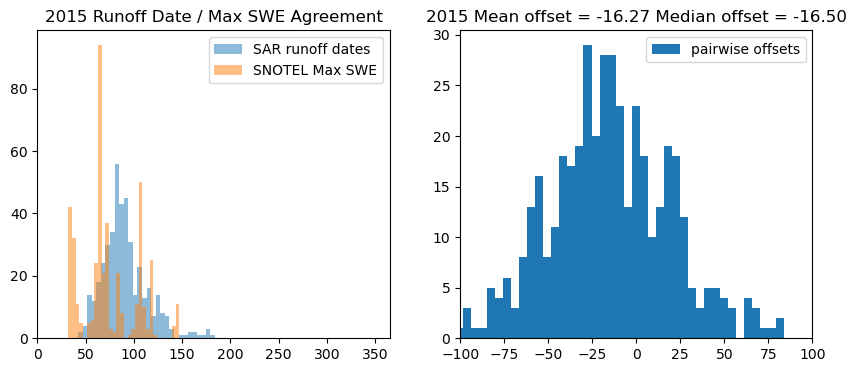

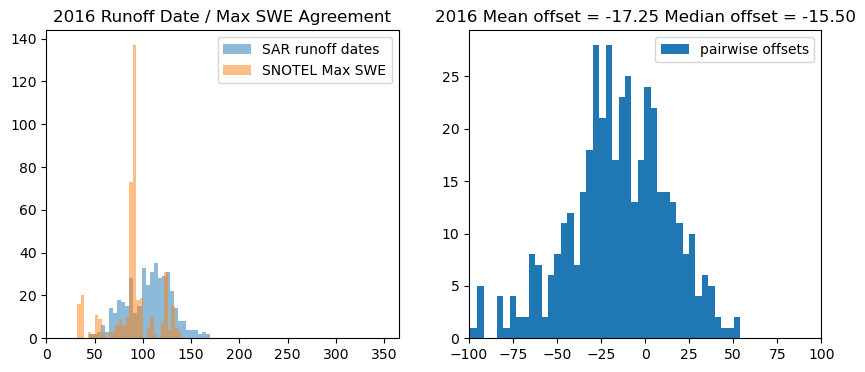

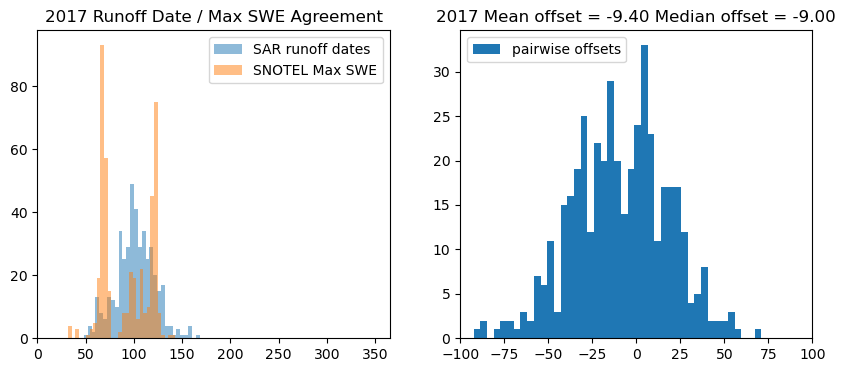

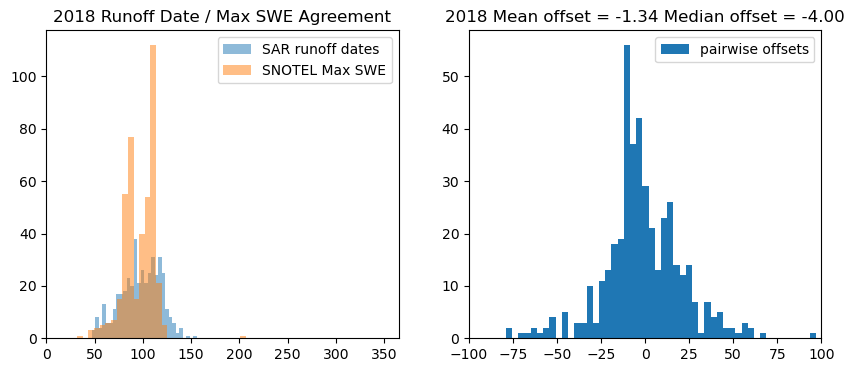

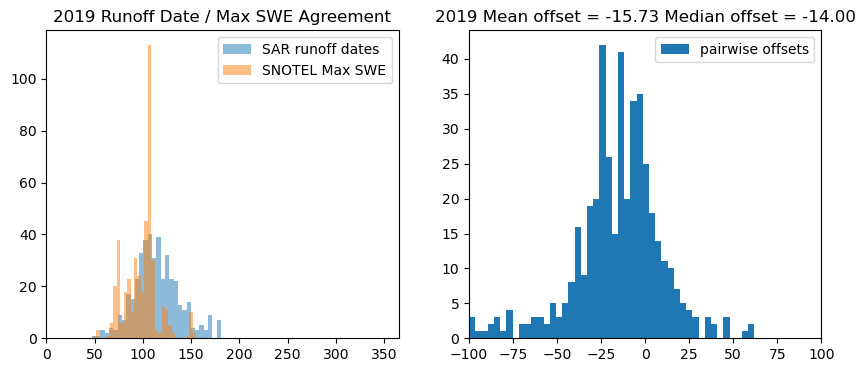

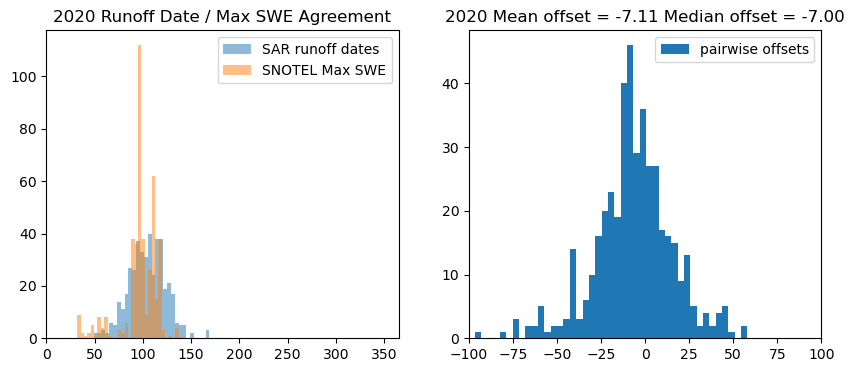

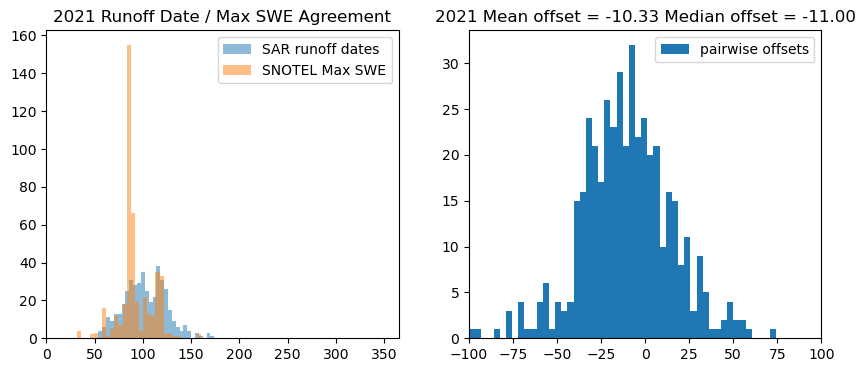

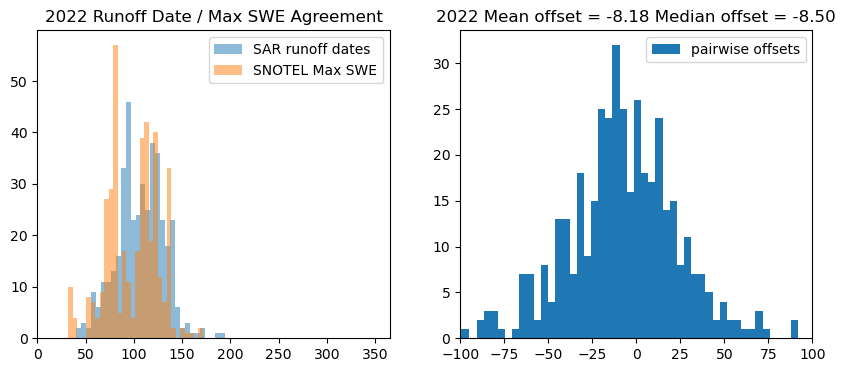

In [27]:
for year in years:
        f,ax=plt.subplots(1,2,figsize=(10,4))
        pairwise = snotel_gf[snotel_gf[[f'sar_runoff_{year}', f'max_swe_{year}']].notnull().all(1)]
        ax[0].hist(pairwise[f'sar_runoff_{year}'],bins=30,alpha=0.5,label='SAR runoff dates')
        ax[0].hist(pairwise[f'max_swe_{year}'],bins=30,alpha=0.5,label='SNOTEL Max SWE')
        ax[0].legend()
        ax[0].set_xlim([0,365])
        ax[0].set_title(f'{year} Runoff Date / Max SWE Agreement')
        
        ax[1].hist(snotel_gf[f'offset_{year}'],bins=50,label='pairwise offsets')
        ax[1].legend()
        mean = snotel_gf[f'offset_{year}'].mean()
        median = snotel_gf[f'offset_{year}'].median()
        ax[1].set_title(f'{year} Mean offset = {mean:.2f} Median offset = {median:.2f}')
        ax[1].set_xlim([-100,100])

Text(0.5, 0, 'Offset [Days]')

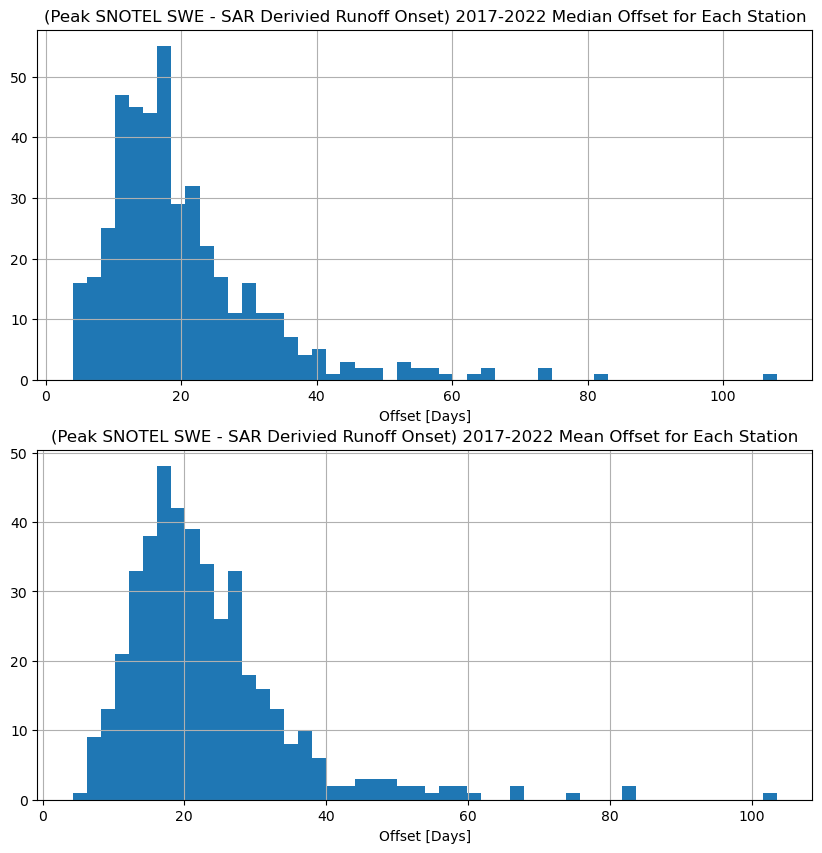

In [28]:
f,ax=plt.subplots(2,1,figsize=(10,10))
snotel_gf['median_offset'].hist(bins=50,ax=ax[0])
snotel_gf['mean_offset'].hist(bins=50,ax=ax[1])
ax[0].set_title('(Peak SNOTEL SWE - SAR Derivied Runoff Onset) 2017-2022 Median Offset for Each Station')
ax[1].set_title('(Peak SNOTEL SWE - SAR Derivied Runoff Onset) 2017-2022 Mean Offset for Each Station')
ax[0].set_xlabel('Offset [Days]')
ax[1].set_xlabel('Offset [Days]')

In [29]:
snotel_gf['median_offset'].median()
# 25 all years
# 22.5 2017 on

17.5

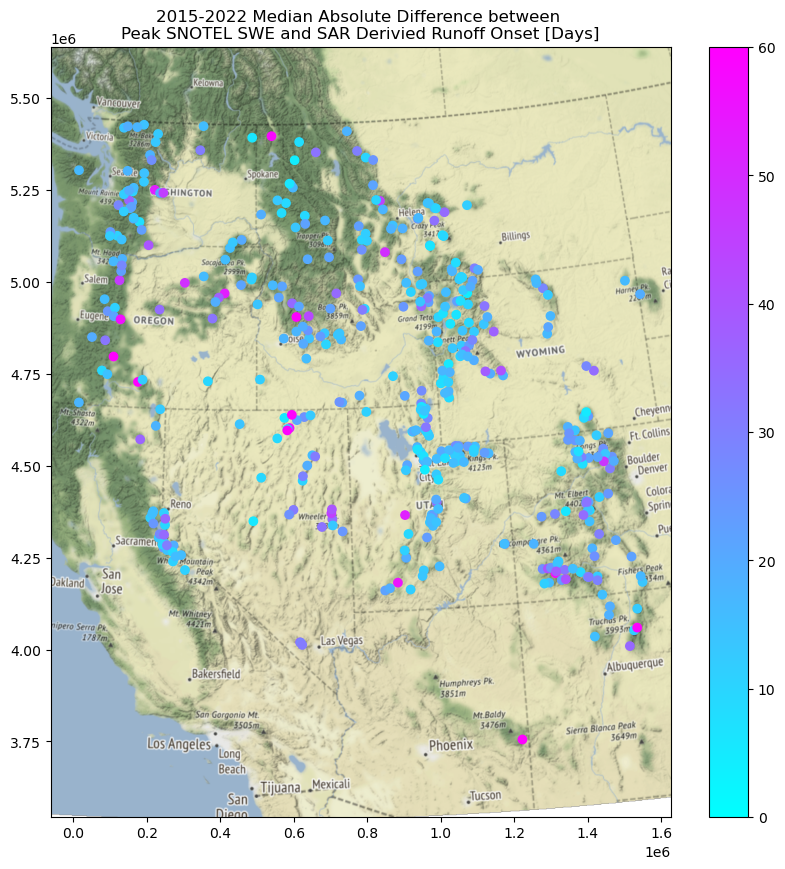

In [30]:
f,ax=plt.subplots(figsize=(10,10))
#snotel_gf_projected = gpd.GeoDataFrame(snotel_gf,geometry=gf.geometry).to_crs('EPSG:32611')
snotel_gf.plot(column='median_offset',ax=ax,legend=True,cmap='cool',vmin=0,vmax=60)
ax.axis('equal')
ax.set_title('2015-2022 Median Absolute Difference between \nPeak SNOTEL SWE and SAR Derivied Runoff Onset [Days]')
ctx.add_basemap(ax=ax, crs=snotel_gf.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

In [31]:
tooltip_list = ['code','name','elevation_m']
for year in years:
    tooltip_list.append(f'offset_{year}')  
    tooltip_list.append(f'sar_runoff_{year}_std') 
tooltip_list.extend(['median_offset','mean_offset','sar_runoff_pixel_count'])

In [32]:
snotel_gf = snotel_gf.drop(['beginDate','endDate','isActive'],axis=1)

In [33]:
snotel_gf.explore(column='median_offset',cmap='cool',tooltip=tooltip_list,vmin=0,vmax=60)

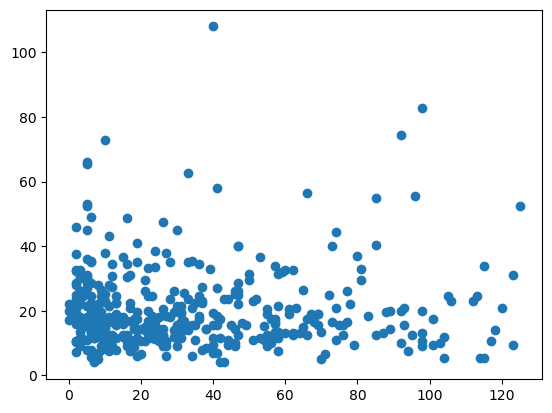

In [34]:
f,ax=plt.subplots()
ax.scatter(snotel_gf['sar_runoff_pixel_count'],snotel_gf['median_offset'])
#ax.set_xlim([0,10])

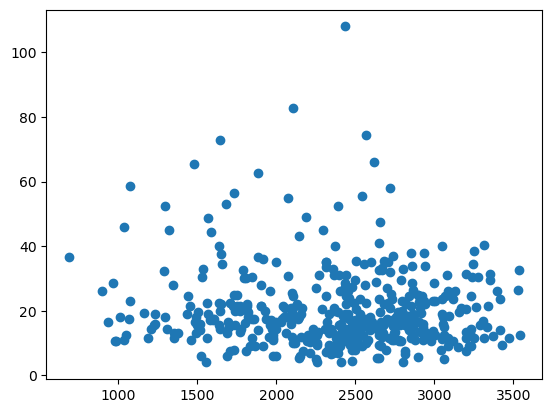

In [35]:
f,ax=plt.subplots()
ax.scatter(snotel_gf['elevation_m'],snotel_gf['median_offset'])

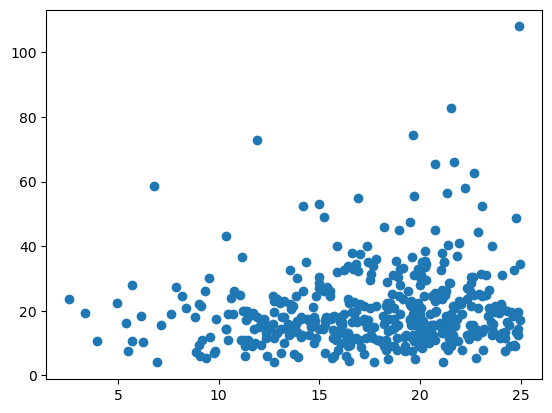

In [36]:
f,ax=plt.subplots()
ax.scatter(snotel_gf['mean_std'],snotel_gf['median_offset'])

In [37]:
corr = snotel_gf.corr()
corr.style.background_gradient(cmap='coolwarm')

,elevation_m,latitude,longitude,timeseries,max_swe_2015,max_swe_2016,max_swe_2017,max_swe_2018,max_swe_2019,max_swe_2020,max_swe_2021,max_swe_2022,sar_runoff_2015,sar_runoff_2015_std,sar_runoff_2016,sar_runoff_2016_std,sar_runoff_2017,sar_runoff_2017_std,sar_runoff_2018,sar_runoff_2018_std,sar_runoff_2019,sar_runoff_2019_std,sar_runoff_2020,sar_runoff_2020_std,sar_runoff_2021,sar_runoff_2021_std,sar_runoff_2022,sar_runoff_2022_std,sar_runoff_pixel_count,offset_2015,offset_2016,offset_2017,offset_2018,offset_2019,offset_2020,offset_2021,offset_2022,median_offset,mean_offset,mean_std
elevation_m,1.000000,-0.745938,0.751235,0.061055,0.424969,0.427471,0.179848,0.027293,0.429122,0.304668,0.212845,0.107060,-0.031014,-0.063173,0.321091,0.088123,0.157681,0.233307,-0.075801,0.268945,0.282690,0.001767,0.133856,0.131848,0.073790,0.280766,0.001313,0.172179,0.178913,0.360923,0.069264,0.027953,0.043037,0.035349,0.106157,0.060244,0.074893,-0.080771,-0.144865,0.267050
latitude,-0.745938,1.000000,-0.454117,-0.027512,-0.038416,0.033001,0.229788,0.441604,0.036327,0.161184,0.231667,0.368764,0.041429,-0.023857,-0.213953,-0.148823,-0.033563,-0.162994,0.274470,-0.337485,-0.075981,0.012653,0.056169,-0.128019,0.158653,-0.195474,0.147524,-0.131339,-0.169680,-0.062874,0.200931,0.245605,0.084405,0.092604,0.093301,0.029970,0.204911,-0.112779,-0.078920,-0.276511
longitude,0.751235,-0.454117,1.000000,0.019693,0.351122,0.339809,-0.028849,0.051972,0.256816,0.240480,0.210851,0.123419,-0.095757,-0.146375,0.240539,0.033734,0.004457,0.219698,-0.066826,0.188648,0.147355,0.078995,0.127311,0.114719,0.050287,0.249394,-0.042745,0.142293,-0.016107,0.345837,0.087881,-0.035576,0.067613,0.045803,0.067996,0.093660,0.130860,-0.042383,-0.092861,0.198294
timeseries,0.061055,-0.027512,0.019693,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,0.070484,-0.034852,-0.033695,0.057211,0.039850,0.020435,-0.070594,0.018229,0.029860,0.012997,0.036316,0.039293,-0.009371,0.027959,0.021052,-0.022815,-0.066203,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.026022
max_swe_2015,0.424969,-0.038416,0.351122,nan,1.000000,0.556783,0.560949,0.468257,0.600395,0.502876,0.602325,0.528269,0.042034,-0.119797,0.207991,-0.109964,0.183141,0.104022,0.124706,-0.083282,0.157430,0.016371,0.250430,-0.016160,0.233265,0.066103,0.145503,0.020884,-0.071635,0.766510,0.269839,0.377800,0.231653,0.269034,0.187790,0.198184,0.322872,-0.220959,-0.278872,-0.035862
max_swe_2016,0.427471,0.033001,0.339809,nan,0.556783,1.000000,0.571545,0.578455,0.635594,0.680069,0.589576,0.593654,0.070847,-0.065689,0.148744,-0.119767,0.186910,0.098107,0.090105,-0.105163,0.250717,0.005919,0.232445,-0.032017,0.234939,0.098900,0.112220,0.030982,-0.092550,0.398776,0.661322,0.383056,0.327613,0.206777,0.349687,0.187726,0.408688,-0.372035,-0.425454,-0.025247
max_swe_2017,0.179848,0.229788,-0.028849,nan,0.560949,0.571545,1.000000,0.613594,0.641417,0.573035,0.617811,0.665355,0.127755,-0.103778,0.151909,-0.151714,0.260054,0.005084,0.267109,-0.172699,0.220047,-0.030209,0.315227,-0.098325,0.334156,-0.022215,0.245424,-0.070054,0.008730,0.367036,0.323163,0.718455,0.196931,0.239490,0.206431,0.121436,0.357099,-0.314467,-0.337072,-0.155467
max_swe_2018,0.027293,0.441604,0.051972,nan,0.468257,0.578455,0.613594,1.000000,0.555713,0.631416,0.630206,0.711382,0.129032,-0.097802,0.035804,-0.216536,0.084707,-0.060842,0.263360,-0.246220,0.190263,-0.036022,0.259225,-0.118116,0.325665,-0.055931,0.200480,-0.017123,-0.064297,0.288167,0.423750,0.494348,0.474341,0.206352,0.287924,0.133114,0.445661,-0.354716,-0.358080,-0.205486
max_swe_2019,0.429122,0.036327,0.256816,nan,0.600395,0.635594,0.641417,0.555713,1.000000,0.600510,0.639401,0.613646,0.040749,-0.057198,0.114232,-0.104792,0.229275,0.135886,0.194105,-0.028582,0.274109,-0.015733,0.236428,-0.026164,0.187072,0.079033,0.203588,0.117623,0.055059,0.451711,0.403834,0.415827,0.222809,0.437840,0.285606,0.264968,0.346131,-0.357196,-0.393670,0.023141
max_swe_2020,0.304668,0.161184,0.240480,nan,0.502876,0.680069,0.573035,0.631416,0.600510,1

In [38]:
snotel_gf.describe()

,elevation_m,latitude,longitude,max_swe_2015,max_swe_2016,max_swe_2017,max_swe_2018,max_swe_2019,max_swe_2020,max_swe_2021,...,offset_2016,offset_2017,offset_2018,offset_2019,offset_2020,offset_2021,offset_2022,median_offset,mean_offset,mean_std
count,473.000000,473.000000,473.000000,433.000000,435.000000,435.000000,433.000000,435.000000,434.000000,436.000000,...,430.000000,435.000000,421.000000,435.000000,434.000000,436.000000,409.000000,437.000000,437.000000,473.000000
mean,2362.120096,42.558749,-113.065845,73.935335,88.928736,91.655172,96.078522,98.818391,96.905530,91.942661,...,-17.254651,-9.400000,-1.342043,-15.729885,-7.109447,-10.332569,-8.182152,20.344966,23.274865,17.570013
std,598.696246,3.308625,4.900410,28.761318,24.341881,25.114405,16.289576,17.642811,18.500055,17.398082,...,31.342508,27.726607,22.509376,25.418502,22.895891,25.566311,31.673258,12.442188,11.892380,4.641499
min,515.112000,33.691441,-123.457474,32.000000,32.000000,32.000000,32.000000,48.000000,32.000000,32.000000,...,-128.000000,-119.000000,-79.000000,-114.000000,-122.000000,-100.000000,-111.000000,4.000000,4.250000,2.562500
25%,1961.692749,39.677120,-116.122330,61.000000,88.000000,68.000000,85.000000,85.000000,93.000000,85.000000,...,-31.875000,-29.000000,-12.000000,-27.000000,-18.000000,-27.000000,-25.000000,12.500000,15.937500,14.184456
50%,2438.399902,42.562481,-111.709999,66.000000,91.000000,94.000000,100.000000,104.000000,98.000000,87.000000,...,-15.500000,-9.000000,-4.000000,-14.000000,-7.000000,-11.000000,-8.500000,17.500000,20.875000,18.389199
75%,2812.694336,45.077068,-109.878151,104.000000,96.000000,119.000000,108.000000,107.000000,109.000000,102.000000,...,4.500000,8.750000,12.000000,-2.000000,5.000000,5.000000,12.000000,24.500000,27.437500,21.222068
max,3541.775879,48.980751,-103.976883,147.000000,140.000000,143.000000,207.000000,155.000000,137.000000,160.000000,...,54.000000,71.000000,97.000000,62.000000,58.000000,74.500000,92.000000,108.000000,103.625000,24.955974


2023-03-07 19:42:23,372 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
